# GR5398 26 Spring: FinRL-Trading Quantitative Trading Strategy Track
## Assignment 1

In this assignment 1, we want you to :
+ Run this ipynb file, which is a simplified FinRL-Trading whole process, and have a basic knowledge of what we will do in this semester
+ Design a portfolio using the selected stocks, and learn some fundamental information of quantitative trading (especially stock selection part)
+ Implement a full backtest process to verify your strategy's performance using real historical data
+ Summarize your result in a very brief research report, and write a `Medium Blog`. Submit your code files onto GitHub repo in a new folder called Assignment1_Name_UNI.
    + An example of medium blog: [Applying new LLMs on FinGPT: Fine-tune DeepSeek and Llama3](https://medium.com/p/6ac9198d88b2)

Assignment 1 Report Submission Due Day: **Feb 20, 2026**.

For full `FinRL-Trading` project, please refer to [AI4Finance/FinRL-Trading](https://github.com/AI4Finance-Foundation/FinRL-Trading/tree/master_backup).

### 0. Prerequisities

First, you should decide your stock pool for later selection. Here we recommend you to choose your portfolio from S&P 500 index or NASDAQ 100 index. We have already provided you with their components.

Then, you should download stock's daily OHLCV data on [WRDS-Security Daily](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/) and quarterly fundamental data on [WRDS-Fundamental Quarterly](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-daily/) for later usage.

+ Note: Here we highly recommend you to register for a WRDS account which our university has provided for all master students for free. Please follow the instruction below to get a WRDS account:
    + https://guides.library.columbia.edu/wrds

If you don't have enough storage or want this data file to be loaded faster while doing calculation, you can select these columns below only while querying the WRDS database.
+ prccd (Price - Close - Daily)
+ prcod (Price - Open - Daily)
+ ajexdi (Adjustment Factor (Issue)-Cumulative by Ex-Date)
+ tic (Ticker)

Since we want you to implement backtest from **Jan 1, 2018** to **Dec 31, 2025**, we suggest you to download all the data during this period.

### 1. Data Preprocessing

In this part, we will preprocess all the fundamental data for our Machine Learning algorithms. Please refer to [AI4Finance/FinRL-Trading/data_processor/Step2_preprocess_fundmental_data.py](https://github.com/AI4Finance-Foundation/FinRL-Trading/blob/master_backup/data_processor/Step2_preprocess_fundmental_data.py) for detailed usage.

After running this part, you should get a folder with final fundamental ratios split into different industry sections in `xlsx` files.

In [74]:
import os
import pandas as pd
import numpy as np
import warnings
from datetime import datetime as dt
import sys
import time
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")

In [75]:
def load_data(fundamental_file, price_file):
    """
    Load fundamental and price data from CSV files.
    
    Args:
        fundamental_file (str): Path to fundamental data CSV file
        price_file (str): Path to price data CSV file
        
    Returns:
        tuple: (fundamental_df, price_df)
    """
    print("Loading data files...")
    
    if not os.path.isfile(fundamental_file):
        raise FileNotFoundError(f"Fundamental file {fundamental_file} not found.")
    
    if not os.path.isfile(price_file):
        raise FileNotFoundError(f"Price file {price_file} not found.")
    
    # Load fundamental data
    fund_df = pd.read_csv(fundamental_file)
    print(fund_df.head())
    
    # For price data, only load necessary columns to save memory
    print("Loading price data (only necessary columns)...")
    price_columns = ['gvkey', 'tic', 'datadate', 'prccd', 'ajexdi']
    df_daily_price = pd.read_csv(price_file, usecols=price_columns)
    print(df_daily_price.head())
    
    print(f"Fundamental data shape: {fund_df.shape}")
    print(f"Price data shape: {df_daily_price.shape}")
    print(f"Unique tickers in fundamental data: {len(fund_df.tic.unique())}")
    print(f"Unique tickers in price data: {len(df_daily_price.tic.unique())}")
    
    return fund_df, df_daily_price

In [76]:
def adjust_trade_dates(fund_df):
    """
    Adjust trade dates to use trading dates instead of quarterly report dates.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with adjusted trade dates
    """
    print("Adjusting trade dates...")
    
    # Convert datadate to datetime first, then to integer format
    datadate_dt = pd.to_datetime(fund_df['datadate'])

    fund_df['tradedate'] = ((datadate_dt.dt.to_period('Q')).dt.end_time.dt.normalize())
    fund_df['reportdate'] = fund_df["rdq"]
    
    return fund_df

In [77]:
def calculate_adjusted_close(fund_df):
    """
    Calculate adjusted close price.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with adjusted close price
    """
    print("Calculating adjusted close price...")
    fund_df['adj_close_q'] = fund_df.prccq / fund_df.adjex
    return fund_df

In [78]:
def match_tickers_and_gvkey(fund_df, df_daily_price):
    """
    Match tickers and gvkey for fundamental and price data.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        df_daily_price (pandas.DataFrame): Price data DataFrame
        
    Returns:
        pandas.DataFrame: Filtered fundamental data DataFrame
    """
    print("Matching tickers and gvkey...")
    
    # Create mapping from ticker to gvkey
    tic_to_gvkey = {}
    df_daily_groups = list(df_daily_price.groupby('tic'))
    
    for tic, df_ in df_daily_groups:
        tic_to_gvkey[tic] = df_.gvkey.iloc[0]
    
    print(f"Original fundamental data shape: {fund_df.shape}")
    
    # Filter fundamental data to only include tickers present in price data
    fund_df = fund_df[np.isin(fund_df.tic, list(tic_to_gvkey.keys()))]
    
    print(f"Filtered fundamental data shape: {fund_df.shape}")
    print(f"Unique gvkeys: {len(fund_df.gvkey.unique())}")
    
    # Add gvkey mapping
    fund_df['gvkey'] = [tic_to_gvkey[x] for x in fund_df['tic']]
    
    return fund_df

In [79]:
def calculate_next_quarter_returns(fund_df):
    """
    Calculate next quarter's return for each stock.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with next quarter returns
    """
    print("Calculating next quarter returns...")
    
    fund_df['date'] = fund_df["tradedate"]
    # fund_df['date'] = pd.to_datetime(fund_df['date'], format="%Y-%m%d")
    fund_df['date'] = pd.to_datetime(fund_df['date'])
    fund_df.drop_duplicates(["date", "gvkey"], keep='last', inplace=True)
    
    # Calculate next quarter return for each stock
    l_df = list(fund_df.groupby('gvkey'))
    for tic, df in l_df:
        df.reset_index(inplace=True, drop=True)
        df.sort_values('date')
        # Calculate next quarter's return
        df['y_return'] = np.log(df['adj_close_q'].shift(-1) / df['adj_close_q'])
    
    fund_df = pd.concat([x[1] for x in l_df])
    
    print(f"Data shape after calculating returns: {fund_df.shape}")
    return fund_df

In [80]:
def calculate_basic_ratios(fund_df):
    """
    Calculate basic financial ratios (PE, PS, PB).
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with basic ratios
    """
    print("Calculating basic financial ratios...")
    
    fund_df['pe'] = fund_df.prccq / fund_df.epspxq
    fund_df['ps'] = fund_df.prccq / (fund_df.revtq / fund_df.cshoq)
    fund_df['pb'] = fund_df.prccq / ((fund_df.atq - fund_df.ltq) / fund_df.cshoq)
    
    return fund_df

In [81]:
def select_columns(fund_df):
    """
    Select relevant columns for analysis.
    
    Args:
        fund_df (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with selected columns
    """
    print("Selecting relevant columns...")
    
    items = [
        'date', 'gvkey', 'tic', 'gsector',
        'oiadpq', 'revtq', 'niq', 'atq', 'teqq', 'epspiy', 'ceqq', 'cshoq', 'dvpspq',
        'actq', 'lctq', 'cheq', 'rectq', 'cogsq', 'invtq', 'apq', 'dlttq', 'dlcq', 'ltq',
        'pe', 'ps', 'pb', 'adj_close_q', 'y_return', 'reportdate'
    ]
    
    fund_data = fund_df[items]
    
    # Rename columns for readability
    fund_data = fund_data.rename(columns={
        'oiadpq': 'op_inc_q',
        'revtq': 'rev_q',
        'niq': 'net_inc_q',
        'atq': 'tot_assets',
        'teqq': 'sh_equity',
        'epspiy': 'eps_incl_ex',
        'ceqq': 'com_eq',
        'cshoq': 'sh_outstanding',
        'dvpspq': 'div_per_sh',
        'actq': 'cur_assets',
        'lctq': 'cur_liabilities',
        'cheq': 'cash_eq',
        'rectq': 'receivables',
        'cogsq': 'cogs_q',
        'invtq': 'inventories',
        'apq': 'payables',
        'dlttq': 'long_debt',
        'dlcq': 'short_debt',
        'ltq': 'tot_liabilities'
    })
    
    return fund_data

In [82]:
def calculate_financial_ratios(fund_data):
    """
    Calculate comprehensive financial ratios.
    
    Args:
        fund_data (pandas.DataFrame): Fundamental data DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with all financial ratios
    """
    print("Calculating comprehensive financial ratios...")
    
    # Set data type to series
    date = fund_data['date'].to_frame('date').reset_index(drop=True)
    reportdate = fund_data['reportdate'].to_frame('reportdate').reset_index(drop=True)
    tic = fund_data['tic'].to_frame('tic').reset_index(drop=True)
    gvkey = fund_data['gvkey'].to_frame('gvkey').reset_index(drop=True)
    adj_close_q = fund_data['adj_close_q'].to_frame('adj_close_q').reset_index(drop=True)
    y_return = fund_data['y_return'].to_frame('y_return').reset_index(drop=True)
    gsector = fund_data['gsector'].to_frame('gsector').reset_index(drop=True)
    pe = fund_data['pe'].to_frame('pe').reset_index(drop=True)
    ps = fund_data['ps'].to_frame('ps').reset_index(drop=True)
    pb = fund_data['pb'].to_frame('pb').reset_index(drop=True)
    
    # Profitability ratios
    print("  Calculating profitability ratios...")
    
    # Operating Margin
    OPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='OPM')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            OPM[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            OPM.iloc[i] = np.nan
        else:
            OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i]) / np.sum(fund_data['rev_q'].iloc[i-3:i])
    OPM = pd.Series(OPM).to_frame().reset_index(drop=True)
    
    # Net Profit Margin
    NPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='NPM')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            NPM[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            NPM.iloc[i] = np.nan
        else:
            NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / np.sum(fund_data['rev_q'].iloc[i-3:i])
    NPM = pd.Series(NPM).to_frame().reset_index(drop=True)
    
    # Return On Assets
    ROA = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='ROA')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            ROA[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            ROA.iloc[i] = np.nan
        else:
            ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / fund_data['tot_assets'].iloc[i]
    ROA = pd.Series(ROA).to_frame().reset_index(drop=True)
    
    # Return on Equity
    ROE = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='ROE')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            ROE[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            ROE.iloc[i] = np.nan
        else:
            ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i]) / fund_data['sh_equity'].iloc[i]
    ROE = pd.Series(ROE).to_frame().reset_index(drop=True)
    
    # Per share items
    EPS = fund_data['eps_incl_ex'].to_frame('EPS').reset_index(drop=True)
    BPS = (fund_data['com_eq'] / fund_data['sh_outstanding']).to_frame('BPS').reset_index(drop=True)
    DPS = fund_data['div_per_sh'].to_frame('DPS').reset_index(drop=True)
    
    # Liquidity ratios
    print("  Calculating liquidity ratios...")
    cur_ratio = (fund_data['cur_assets'] / fund_data['cur_liabilities']).to_frame('cur_ratio').reset_index(drop=True)
    quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables']) / fund_data['cur_liabilities']).to_frame('quick_ratio').reset_index(drop=True)
    cash_ratio = (fund_data['cash_eq'] / fund_data['cur_liabilities']).to_frame('cash_ratio').reset_index(drop=True)
    
    # Efficiency ratios
    print("  Calculating efficiency ratios...")
    
    # Inventory turnover ratio
    inv_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='inv_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            inv_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            inv_turnover.iloc[i] = np.nan
        else:
            inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i]) / fund_data['inventories'].iloc[i]
    inv_turnover = pd.Series(inv_turnover).to_frame().reset_index(drop=True)
    
    # Receivables turnover ratio
    acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='acc_rec_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            acc_rec_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            acc_rec_turnover.iloc[i] = np.nan
        else:
            acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i]) / fund_data['receivables'].iloc[i]
    acc_rec_turnover = pd.Series(acc_rec_turnover).to_frame().reset_index(drop=True)
    
    # Payable turnover ratio
    acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name='acc_pay_turnover')
    for i in range(0, fund_data.shape[0]):
        if i-3 < 0:
            acc_pay_turnover[i] = np.nan
        elif fund_data.iloc[i, 1] != fund_data.iloc[i-3, 1]:
            acc_pay_turnover.iloc[i] = np.nan
        else:
            acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i]) / fund_data['payables'].iloc[i]
    acc_pay_turnover = pd.Series(acc_pay_turnover).to_frame().reset_index(drop=True)
    
    # Leverage ratios
    print("  Calculating leverage ratios...")
    debt_ratio = (fund_data['tot_liabilities'] / fund_data['tot_assets']).to_frame('debt_ratio').reset_index(drop=True)
    debt_to_equity = (fund_data['tot_liabilities'] / fund_data['sh_equity']).to_frame('debt_to_equity').reset_index(drop=True)
    
    # Create final ratios dataframe
    ratios = pd.concat([
        date, gvkey, tic, gsector, adj_close_q, y_return,
        OPM, NPM, ROA, ROE, EPS, BPS, DPS,
        cur_ratio, quick_ratio, cash_ratio, inv_turnover, acc_rec_turnover, acc_pay_turnover,
        debt_ratio, debt_to_equity, pe, ps, pb, reportdate
    ], axis=1).reset_index(drop=True)
    
    return ratios

In [83]:
def handle_missing_values(ratios):
    """
    Handle missing values and infinite values in the dataset.
    
    Args:
        ratios (pandas.DataFrame): DataFrame with financial ratios
        
    Returns:
        pandas.DataFrame: Cleaned DataFrame
    """
    print("Handling missing values...")
    
    # Replace NAs and infinite values with zero initially
    final_ratios = ratios.copy()
    final_ratios = final_ratios.fillna(0)
    final_ratios = final_ratios.replace(np.inf, 0)
    
    # Define financial features columns
    features_column_financial = [
        'OPM', 'NPM', 'ROA', 'ROE', 'EPS', 'BPS', 'DPS', 'cur_ratio',
        'quick_ratio', 'cash_ratio', 'inv_turnover', 'acc_rec_turnover',
        'acc_pay_turnover', 'debt_ratio', 'debt_to_equity', 'pe', 'ps', 'pb'
    ]
    
    # Remove rows with zero adjusted close price
    final_ratios = final_ratios.drop(list(final_ratios[final_ratios.adj_close_q == 0].index)).reset_index(drop=True)
    
    # Convert to numeric and handle invalid values
    final_ratios['y_return'] = pd.to_numeric(final_ratios['y_return'], errors='coerce')
    for col in features_column_financial:
        if col in final_ratios.columns:
            final_ratios[col] = pd.to_numeric(final_ratios[col], errors='coerce')
    
    final_ratios['y_return'].replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
    final_ratios[features_column_financial].replace([np.nan, np.inf, -np.inf], np.nan, inplace=True)
    
    # Remove columns with too many invalid values
    dropped_col = []
    for col in features_column_financial:
        if col in final_ratios.columns and np.any(~np.isfinite(final_ratios[col])):
            final_ratios.drop(columns=[col], axis=1, inplace=True)
            dropped_col.append(col)
    
    # Remove rows with any missing values
    final_ratios.dropna(axis=0, inplace=True)
    final_ratios = final_ratios[final_ratios["reportdate"].ne(0)]  
    final_ratios = final_ratios.reset_index(drop=True)
    
    print(f"Dropped columns: {dropped_col}")
    print(f"Final data shape: {final_ratios.shape}")
    
    return final_ratios

In [84]:
def save_results(final_ratios, output_dir="outputs", include_sector0=False):
    """
    Save the processed data to files.
    
    Args:
        final_ratios (pandas.DataFrame): Final processed data
        output_dir (str): Output directory
        include_sector0 (bool): Whether to include sector 0 in sector-specific files (default: False)
    """
    print("Saving results...")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Format date column
    # final_ratios.date = final_ratios.date.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # Save main results
    main_output_file = os.path.join(output_dir, 'final_ratios.csv')
    final_ratios.to_csv(main_output_file, index=False)
    print(f"Main results saved to: {main_output_file}")
    
    # Save by sector
    print("Saving sector-specific files...")
    sector_count = 0
    for sec, df_ in list(final_ratios.groupby('gsector')):
        # Skip sector 0 unless explicitly included
        if sec == 0 and not include_sector0:
            print(f"  Skipping Sector 0: {len(df_)} records (stocks with missing sector information)")
            continue
        
        sector_file = os.path.join(output_dir, f"sector{int(sec)}.xlsx")
        df_.to_excel(sector_file, index=False)
        print(f"  Sector {int(sec)}: {sector_file} ({len(df_)} records)")
        sector_count += 1
    
    print(f"  Total sectors saved: {sector_count}")
    
    return main_output_file

In [87]:
Stock_Index_fundation_file = "/Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/fundamental_data.csv" ### Path of your stocks' fundamental data
Stock_Index_price_file = "/Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/daily.csv" ### Path of your stocks' daily performance data
output_dir = "/Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output" ### Where do you like to output your results
include_sector0 = False

In [88]:
print("=" * 80)
print("S&P 500 Fundamental Data Preprocessing Tool")
print("=" * 80)
print(f"Fundamental file: {Stock_Index_fundation_file}")
print(f"Price file: {Stock_Index_price_file}")
print(f"Output directory: {output_dir}")
print(f"Include sector 0 in sector files: {include_sector0}")
print("-" * 80)

# Load data
fund_df, df_daily_price = load_data(Stock_Index_fundation_file, Stock_Index_price_file)

# Process data
fund_df = adjust_trade_dates(fund_df)
fund_df = calculate_adjusted_close(fund_df)
fund_df = match_tickers_and_gvkey(fund_df, df_daily_price)
fund_df = calculate_next_quarter_returns(fund_df)
fund_df = calculate_basic_ratios(fund_df)

# Select and process columns
fund_data = select_columns(fund_df)

# Calculate financial ratios
ratios = calculate_financial_ratios(fund_data)

# Handle missing values
final_ratios = handle_missing_values(ratios)

# Save results
output_file = save_results(final_ratios, output_dir, include_sector0)

print("\n" + "=" * 80)
print("Processing completed successfully!")
print(f"Final dataset shape: {final_ratios.shape}")
print(f"Output saved to: {output_file}")
print("=" * 80)

S&P 500 Fundamental Data Preprocessing Tool
Fundamental file: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/fundamental_data.csv
Price file: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/daily.csv
Output directory: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output
Include sector 0 in sector files: False
--------------------------------------------------------------------------------
Loading data files...
  costat curcdq datafmt indfmt consol  tic    datadate  gvkey  gsector  \
0      A    USD     STD   INDL      C  HON  2012-09-30   1300       20   
1      A    USD     STD   INDL      C  HON  2012-12-31   1300       20   
2      A    USD     STD   INDL      C  HON  2013-03-31   1300       20   
3      A    USD     STD   INDL      C  HON  2016-12-31   1300       20   
4      A    USD     STD   INDL      

### 2. Stock Selection

In this part, we will use processed fundamental data to predict stocks' future return.

To be specific, we will use 3 different machine learning algorithms (Random Forest, LightGBM, XGBoost) to predict next quarter's performance. Instead of setting a specific date to calculate all the future returns, here we optimized to predict dynamically. While there is a new report published, we can immediately renew its latest prediction. Then, we choose stocks with top k% (you can adjust this rate by yourself) predicted return as our portfolio.

For details, please refer to `fundamental_run_model.py` and `ml_model.py`. Also, we recommend you to try DRL stock selection and reallocation algorithm in [AI4Finance/FinRL-Trading/fundamental_portfolio_drl.py](https://github.com/AI4Finance-Foundation/FinRL-Trading/blob/master_backup/fundamental_portfolio_drl.py).

After running this part, you should get a csv file contains all your portfolio's components history.

In [89]:
def create_directory_if_not_exists(directory_path):
    """
    Create directory if it doesn't exist
    
    Args:
        directory_path (str): Directory path
    """
    path = Path(directory_path)
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        print(f"✓ Created directory: {directory_path}")
    else:
        print(f"✓ Directory already exists: {directory_path}")

def quarter_ffill(df: pd.DataFrame) -> pd.DataFrame:
    qkey = df.index.to_period("Q")
    df = df.groupby(qkey).ffill()
    return df

def quarter_reportday_ffill(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    full_idx = pd.bdate_range(df.index.min(), df.index.max())

    out = df.reindex(full_idx)
    out = out.sort_index().copy()
    idx = out.index
    for col in out.columns:
        s = out[col]
        if not s.notna().any():
            continue
        dates = s.dropna().index
        for i, t0 in enumerate(dates):
            val = s.at[t0]
            t1 = dates[i + 1] if i + 1 < len(dates) else None
            cap = (t0.to_period('Q') + 1).end_time.normalize()
            mask = (idx > t0) & (idx < (t1 if t1 and t1 <= cap else cap + pd.Timedelta('1ns')))
            out.loc[mask, col] = val
    return out

In [90]:
import os, glob

print("DATA_DIR =", output_dir)
print("sector files found:", sorted([os.path.basename(x) for x in glob.glob(os.path.join(output_dir, "sector*.xlsx"))])[:20])
print("final_ratios exists:", os.path.exists(os.path.join(output_dir, "final_ratios.csv")))

DATA_DIR = /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output
sector files found: ['sector10.xlsx', 'sector15.xlsx', 'sector20.xlsx', 'sector25.xlsx', 'sector30.xlsx', 'sector35.xlsx', 'sector40.xlsx', 'sector45.xlsx', 'sector50.xlsx', 'sector55.xlsx', 'sector60.xlsx']
final_ratios exists: True


In [91]:
def run_stock_selection(data_path, output_path):
    """
    Run stock selection model
    
    Args:
        data_path (str): Input sector files directory
        output_path (str): Output directory
    """
    # Define sector range
    sectors = range(10, 65, 5)
    
    # Set data directory path
    DATA_DIR = data_path
    FUNDAMENTAL_FILE = os.path.join(DATA_DIR, "final_ratios.csv")
    
    print(f"Using data directory: {DATA_DIR}")
    print(f"Fundamental data file: {FUNDAMENTAL_FILE}")
    print(f"Output directory: {output_path}")
    print(f"Sector range: {list(sectors)}")
    
    # Check if input file exists
    if not os.path.exists(FUNDAMENTAL_FILE):
        print(f"Error: Fundamental data file does not exist: {FUNDAMENTAL_FILE}")
        sys.exit(1)
    
    # Create output directory
    create_directory_if_not_exists(output_path)
    
    # gvkey is unique identifier
    df_dict = {'tic': [], 'predicted_return': [], 'trade_date': []}
    
    # ===== Run stock selection for all sectors in my_outputs directory =====
    start = time.time()
    print("\nStarting stock selection model for all sectors...")

    df_all = pd.DataFrame()
    
    for sector in sectors:
        sector_file = os.path.join(DATA_DIR, f"sector{sector}.xlsx")
        print(f"\nProcessing sector{sector}...")
        
        # Check if sector file exists
        if not os.path.exists(sector_file):
            print(f"   Warning: Sector file does not exist, skipping: {sector_file}")
            continue
        
        # Run model training - using files from specified directory
        cmd = f"{sys.executable} fundamental_run_model.py -sector_name sector{sector} -tic_column tic -fundamental {FUNDAMENTAL_FILE} -sector {sector_file}"
        print(f"Executing command: {cmd}")
        
        result = os.system(cmd)
        if result != 0:
            print(f" sector{sector} model training failed")
            continue
        
        # Read prediction results
        result_file = f"results/sector{sector}/df_predict_best.csv"
        if not os.path.exists(result_file):
            print(f" Prediction result file does not exist: {result_file}")
            continue

        df = pd.read_csv(result_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"  Reading prediction results: {df.shape[0]} dates, {df.shape[1]} stocks")
        df = quarter_reportday_ffill(df)
        df_all = pd.concat([df_all, df], axis=1)
        print(f" sector{sector} processing completed")

    for idx in df_all.index:
        predicted_return = df_all.loc[idx]
        ### Choose top 25% stocks, or you can adjust by yourself
        btm_q = predicted_return.quantile(0.75)
        # top_q = predicted_return.quantile(1)
        predicted_return = predicted_return[predicted_return >= btm_q]
        # predicted_return = predicted_return[(predicted_return >= btm_q) & (predicted_return <= top_q)]
        for tic in predicted_return.index:
            df_dict["tic"].append(tic)
            df_dict["predicted_return"].append(predicted_return[tic])
            df_dict["trade_date"].append(idx)
    
    end = time.time()
    
    print(f"\nTotal time: {(end-start)/60:.2f} minutes")
    print(f"Processing completed! Total records: {len(df_dict['tic'])}")
    
    # Create result DataFrame
    df_result = pd.DataFrame(df_dict)
    
    # Save results to CSV file
    output_file = os.path.join(output_path, "stock_selected.csv")
    df_result.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    
    # Display result statistics
    if len(df_result) > 0:
        print(f"\nResult statistics:")
        print(f"  Total records: {len(df_result)}")
        print(f"  Unique stocks: {df_result['tic'].nunique()}")
        print(f"  Date range: {df_result['trade_date'].min()} to {df_result['trade_date'].max()}")
        print(f"  Predicted return range: {df_result['predicted_return'].min():.4f} to {df_result['predicted_return'].max():.4f}")
    else:
        print("\nWarning: No stock selection results generated")

In [92]:
data_path = output_dir ### Path of your fundamental data's, should be the same of your choice in part 1
output_path_step2 = "/Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/step2" ### Where do you want to output the result file

In [93]:
run_stock_selection(data_path, output_path_step2)

Using data directory: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output
Fundamental data file: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/final_ratios.csv
Output directory: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/step2
Sector range: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
✓ Created directory: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/step2

Starting stock selection model for all sectors...

Processing sector10...
Executing command: /opt/anaconda3/bin/python fundamental_run_model.py -sector_name sector10 -tic_column tic -fundamental /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/final_ratios.csv -sector /Users/gaohan/STAT-GR5398-Spring-2026

### 3. Backtest

In this part, you should use your result from part 2 to design a quantitative trading strategy. Your portfolio's performance should **beat S&P 500** during all the time.

Here we provide you with a simple strategy: equal weight portfolio with buy & hold strategy.

In [94]:
# ============ Equal Weight Portfolio Construction ============
print("=" * 80)
print("Equal Weight Portfolio Construction")
print("=" * 80)

# Step 1: Load selected stocks data
selected_stocks_df = pd.read_csv(os.path.join(output_path_step2, "stock_selected.csv"))
selected_stocks_df['trade_date'] = pd.to_datetime(selected_stocks_df['trade_date'])

print(f"\nSelected stocks data shape: {selected_stocks_df.shape}")
print(f"Date range: {selected_stocks_df['trade_date'].min()} to {selected_stocks_df['trade_date'].max()}")
print(f"Unique stocks: {selected_stocks_df['tic'].nunique()}")
print(f"\nStock list: {sorted(selected_stocks_df['tic'].unique())}")

# Step 2: Load daily price data
price_columns = ['tic', 'datadate', 'prccd']
df_daily_price = pd.read_csv(Stock_Index_price_file, usecols=price_columns)
df_daily_price['datadate'] = pd.to_datetime(df_daily_price['datadate'])
df_daily_price = df_daily_price.rename(columns={'prccd': 'close'})

print(f"\nDaily price data shape: {df_daily_price.shape}")
print(f"Price date range: {df_daily_price['datadate'].min()} to {df_daily_price['datadate'].max()}")

# Step 3: Create portfolio weights dataframe
portfolio_dates = sorted(selected_stocks_df['trade_date'].unique())
all_stocks_in_portfolio = sorted(selected_stocks_df['tic'].unique())

print(f"\nPortfolio dates: {len(portfolio_dates)}")
print(f"All stocks in portfolio: {len(all_stocks_in_portfolio)}")

portfolio_weights_dict = {}

for date in portfolio_dates:
    stocks_on_date = selected_stocks_df[selected_stocks_df['trade_date'] == date]['tic'].unique()
    n_stocks = len(stocks_on_date)
    
    portfolio_weights_dict[date] = {}
    for stock in all_stocks_in_portfolio:
        if stock in stocks_on_date:
            portfolio_weights_dict[date][stock] = 1.0 / n_stocks
        else:
            portfolio_weights_dict[date][stock] = 0.0

portfolio_weights_df = pd.DataFrame(portfolio_weights_dict).T
portfolio_weights_df.index.name = 'date'

print(f"\nPortfolio weights dataframe shape: {portfolio_weights_df.shape}")
print(f"Rows (dates): {portfolio_weights_df.shape[0]}, Columns (stocks): {portfolio_weights_df.shape[1]}")
print(f"\nFirst few dates and weights:")
print(portfolio_weights_df.head(10))
print(f"\nLast few dates and weights:")
print(portfolio_weights_df.tail(10))

weights_sum = portfolio_weights_df.sum(axis=1)
print(f"\nWeights sum check (should all be 1.0):")
print(f"  Min: {weights_sum.min():.6f}")
print(f"  Max: {weights_sum.max():.6f}")
print(f"  Mean: {weights_sum.mean():.6f}")

# Step 4: Save the portfolio weights
portfolio_weights_file = os.path.join(output_path_step2, "portfolio_weights.csv")
portfolio_weights_df.to_csv(portfolio_weights_file)
print(f"\n✓ Portfolio weights saved to: {portfolio_weights_file}")

print("\n" + "=" * 80)
print("Equal weight portfolio constructed successfully!")
print("=" * 80)

Equal Weight Portfolio Construction

Selected stocks data shape: (58974, 3)
Date range: 2017-02-09 00:00:00 to 2026-02-18 00:00:00
Unique stocks: 90

Stock list: ['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'APP', 'ARM', 'ASML', 'AVGO', 'AXON', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CDNS', 'CDW', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DXCM', 'EA', 'FANG', 'FAST', 'FTNT', 'GEHC', 'GFS', 'GILD', 'GOOGL', 'HON', 'IDXX', 'INTC', 'INTU', 'KDP', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MELI', 'META', 'MNST', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PLTR', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SHOP', 'SNPS', 'TEAM', 'TMUS', 'TRI', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'ZS']

Daily price data shape: (318832, 3)
Price date range: 2012-01-03 00:00:00 to 2025-12-31 00:00:00

Portfolio dates: 2355
All stocks in portfol

In [95]:
daily = pd.read_csv("daily.csv", parse_dates=["datadate"])

daily = daily.rename(columns={
    "datadate": "date",
    "prcod": "open",
    "prccd": "close"
})

daily["open_adj"] = daily["open"] / daily["ajexdi"]
daily["close_adj"] = daily["close"] / daily["ajexdi"]

daily["ret"] = daily["close_adj"] / daily["open_adj"] - 1

ret_df = (
    daily
    .pivot(index="date", columns="tic", values="ret")
    .sort_index()
)

portfolio_weights_df = portfolio_weights_df.sort_index()

common_dates = portfolio_weights_df.index.intersection(ret_df.index)
portfolio_weights_df = portfolio_weights_df.loc[common_dates]
ret_df = ret_df.loc[common_dates]

ret_df = ret_df.fillna(0.0)


gross_ret = (portfolio_weights_df * ret_df).sum(axis=1)
turnover = portfolio_weights_df.diff().abs().sum(axis=1)

fee_rate = 0.001  # 0.1%
cost = fee_rate * turnover
cost.iloc[0] = 0.0

net_ret = gross_ret - cost
nav = (1 + net_ret).cumprod()

result = pd.DataFrame({
    "gross_ret": gross_ret,
    "turnover": turnover,
    "cost": cost,
    "net_ret": net_ret,
    "nav": nav
})

initial_date = portfolio_weights_df.index[0] - pd.Timedelta(days=1)
initial_row = pd.DataFrame({
    "gross_ret": [0.0],
    "turnover": [0.0],
    "cost": [0.0],
    "net_ret": [0.0],
    "nav": [1.0]
}, index=[initial_date])

result = pd.concat([initial_row, result], axis=0)
print(f"Result shape: {result.shape}")
print(f"First few rows:\n{result.head()}")

Result shape: (2237, 5)
First few rows:
            gross_ret  turnover  cost   net_ret       nav
2017-02-08   0.000000       0.0   0.0  0.000000  1.000000
2017-02-09  -0.020865       0.0   0.0 -0.020865  0.979135
2017-02-10  -0.052614       0.0   0.0 -0.052614  0.927619
2017-02-13  -0.044184       0.0   0.0 -0.044184  0.886633
2017-02-14   0.007315       0.0   0.0  0.007315  0.893119


Normalizing NAV curves to start from 1.0...
Aligned data shape: (2237, 3)
Date range: 2017-02-08 00:00:00 to 2025-12-31 00:00:00
Chart saved to: portfolio_comparison_chart.png


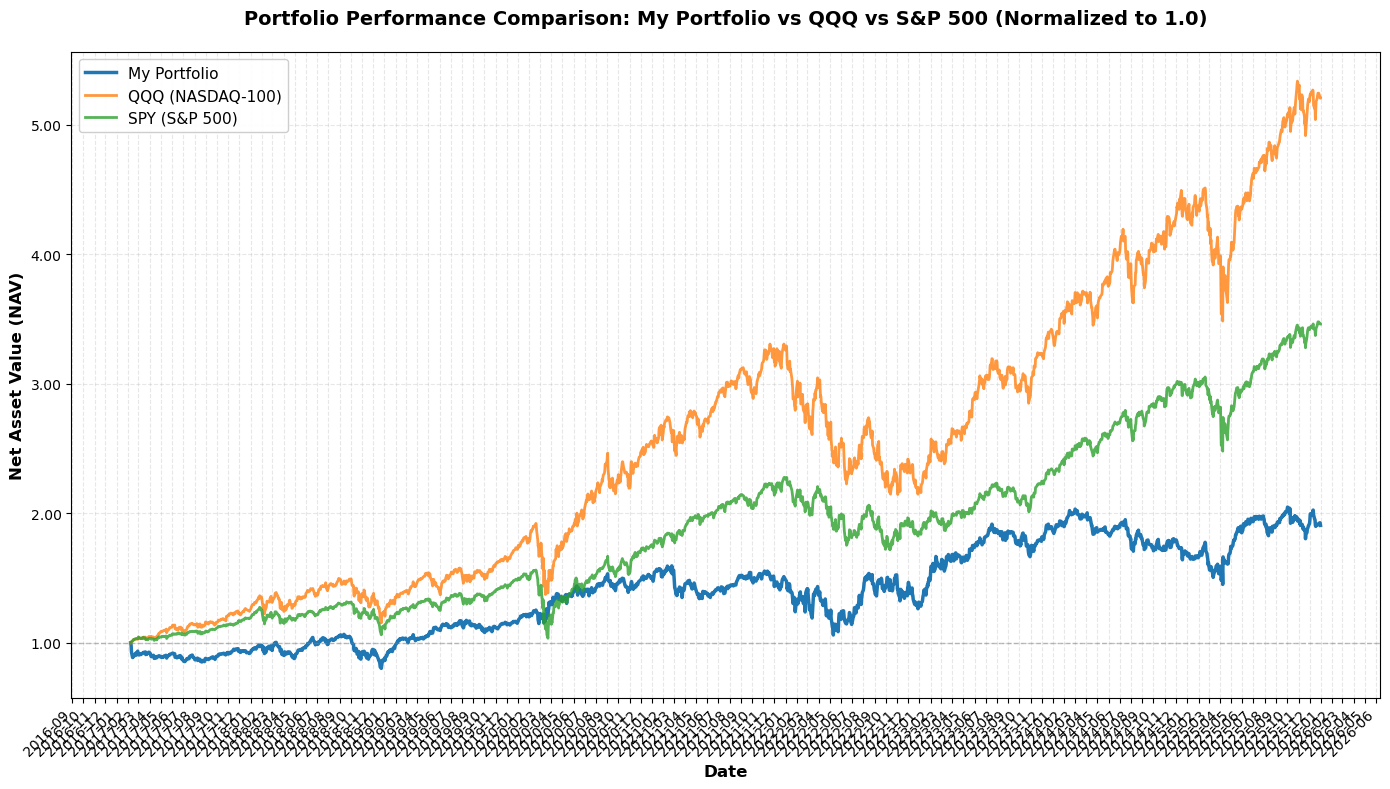

In [96]:
QQQ = yf.download("QQQ", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)
spy = yf.download("SPY", start=result.index.min(), end=result.index.max(), progress=False, multi_level_index=False)

qqq_nav = QQQ['Close'] / QQQ['Close'].iloc[0]
spy_nav = spy['Close'] / spy['Close'].iloc[0]

# Create a dataframe with all NAVs
comparison_df = pd.DataFrame({
    'Portfolio': result['nav'],
    'QQQ': qqq_nav,
    'SPY': spy_nav
})

# Forward fill to handle missing dates
comparison_df = comparison_df.fillna(method='ffill')

# Remove rows with NaN
comparison_df = comparison_df.dropna()

# Normalize all NAV curves to start from 1.0
print("Normalizing NAV curves to start from 1.0...")
comparison_df = comparison_df / comparison_df.iloc[0]

print(f"Aligned data shape: {comparison_df.shape}")
print(f"Date range: {comparison_df.index.min()} to {comparison_df.index.max()}")

fig, ax = plt.subplots(figsize=(14, 8))

# Plot NAV curves
ax.plot(comparison_df.index, comparison_df['Portfolio'], label='My Portfolio', linewidth=2.5, color='#1f77b4')
ax.plot(comparison_df.index, comparison_df['QQQ'], label='QQQ (NASDAQ-100)', linewidth=2, color='#ff7f0e', alpha=0.8)
ax.plot(comparison_df.index, comparison_df['SPY'], label='SPY (S&P 500)', linewidth=2, color='#2ca02c', alpha=0.8)

# Add horizontal line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Asset Value (NAV)', fontsize=12, fontweight='bold')
ax.set_title('Portfolio Performance Comparison: My Portfolio vs QQQ vs S&P 500 (Normalized to 1.0)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

plt.tight_layout()

# Save figure
output_file = 'portfolio_comparison_chart.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Chart saved to: {output_file}")

plt.show()

In [ ]:
###########################################################################
# Your own strategy and visulization can be built based on the above code #
###########################################################################



Running: topN=30, mom_window=63, cap=0.05 ...
Running: topN=30, mom_window=63, cap=0.08 ...
Running: topN=30, mom_window=63, cap=0.1 ...
Running: topN=30, mom_window=126, cap=0.05 ...
Running: topN=30, mom_window=126, cap=0.08 ...
Running: topN=30, mom_window=126, cap=0.1 ...
Running: topN=30, mom_window=252, cap=0.05 ...
Running: topN=30, mom_window=252, cap=0.08 ...
Running: topN=30, mom_window=252, cap=0.1 ...
Running: topN=50, mom_window=63, cap=0.05 ...
Running: topN=50, mom_window=63, cap=0.08 ...
Running: topN=50, mom_window=63, cap=0.1 ...
Running: topN=50, mom_window=126, cap=0.05 ...
Running: topN=50, mom_window=126, cap=0.08 ...
Running: topN=50, mom_window=126, cap=0.1 ...
Running: topN=50, mom_window=252, cap=0.05 ...
Running: topN=50, mom_window=252, cap=0.08 ...
Running: topN=50, mom_window=252, cap=0.1 ...
Running: topN=80, mom_window=63, cap=0.05 ...
Running: topN=80, mom_window=63, cap=0.08 ...
Running: topN=80, mom_window=63, cap=0.1 ...
Running: topN=80, mom_window=

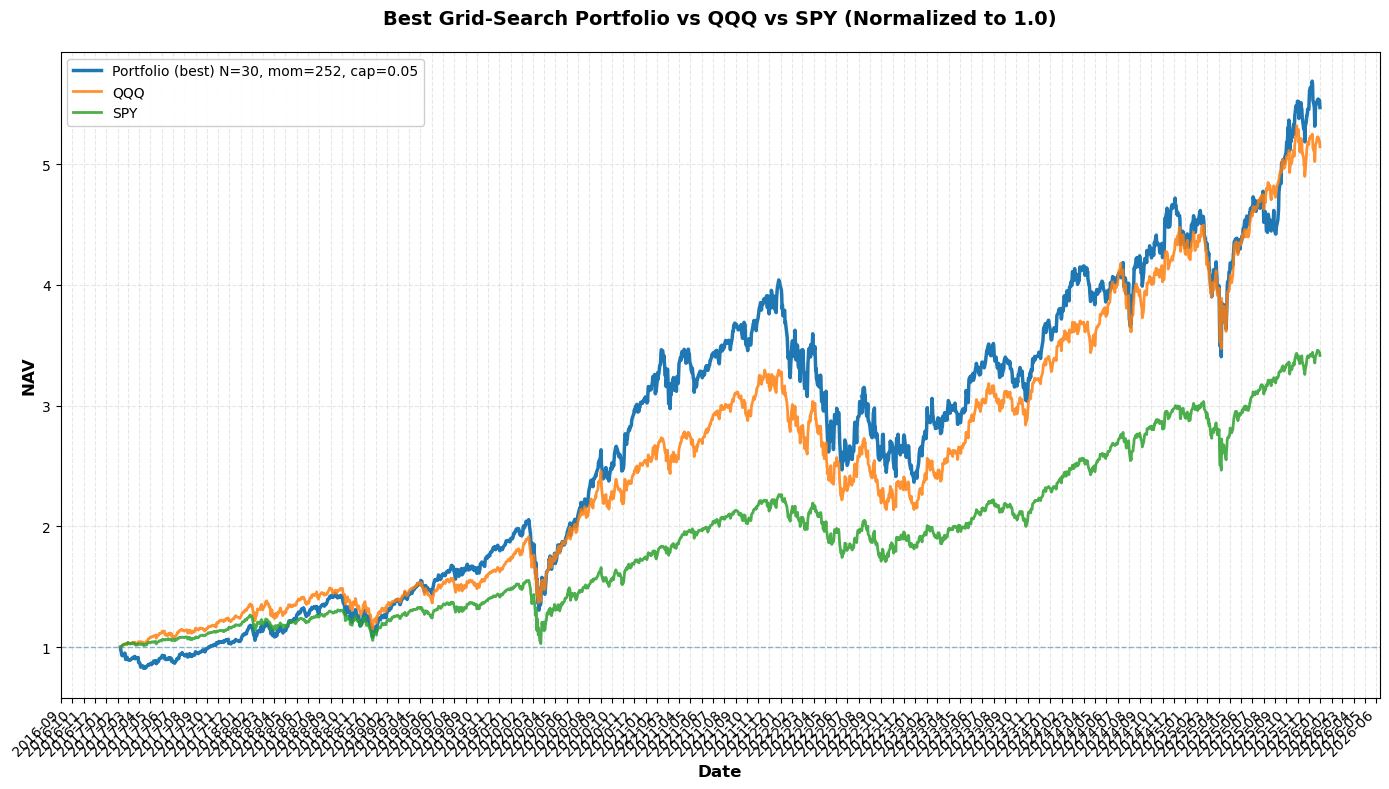

In [ ]:
# ============================================================
# GRID SEARCH (auto tuning) for:
#   - topN: 30 / 50 / 80
#   - mom_window: 63 / 126 / 252
#   - weight_cap: 0.05 / 0.08 / 0.10
#

# ============================================================
# -------------------------
# 1) Build close-to-close returns ONCE (recommended)
# -------------------------
daily = pd.read_csv(daily_csv_path, parse_dates=["datadate"])
daily = daily.rename(columns={"datadate": "date", "prccd": "close"})
daily["close_adj"] = daily["close"] / daily["ajexdi"]
daily = daily.sort_values(["tic", "date"])

# close-to-close ret
daily["ret"] = daily.groupby("tic")["close_adj"].pct_change()
ret_df = daily.pivot(index="date", columns="tic", values="ret").sort_index()

# prices for momentum
px = daily.pivot(index="date", columns="tic", values="close_adj").sort_index()

# selected universe (your file)
selected_file = os.path.join(output_path_step2, "stock_selected.csv")
sel = pd.read_csv(selected_file)
sel["trade_date"] = pd.to_datetime(sel["trade_date"])
portfolio_dates = sorted(sel["trade_date"].unique())
all_tics = sorted(sel["tic"].unique())

# -------------------------
# 2) Helper: build weights given params
# -------------------------
def build_weights_mom_invvol(
    topN: int,
    mom_window: int,
    weight_cap: float,
    vol_window: int = 60,
    min_names: int = 10
) -> pd.DataFrame:
    # compute signals (vectorized precompute)
    mom = px.pct_change(mom_window)
    vol = ret_df.rolling(vol_window).std() * np.sqrt(252)

    weights = {}
    for d in portfolio_dates:
        d = pd.Timestamp(d)
        if d not in mom.index or d not in vol.index:
            continue

        u = sel.loc[sel["trade_date"] == d, "tic"].unique().tolist()
        if len(u) == 0:
            continue

        mom_d = mom.loc[d, u]
        vol_d = vol.loc[d, u]

        # momentum filter: keep mom > 0
        u2 = [tic for tic in u if pd.notna(mom_d.get(tic, np.nan)) and mom_d[tic] > 0]
        if len(u2) < min_names:
            u2 = u  # fallback

        # rank by momentum, pick topN
        mom_rank = mom_d[u2].dropna().sort_values(ascending=False)
        picked = mom_rank.head(min(topN, len(mom_rank))).index.tolist()
        if len(picked) == 0:
            continue

        # inverse-vol weights
        v = vol_d[picked].replace(0.0, np.nan).dropna()
        picked = v.index.tolist()
        if len(picked) == 0:
            continue

        w = (1.0 / v)
        w = w / w.sum()

        # cap + renormalize
        w = w.clip(upper=weight_cap)
        w = w / w.sum()

        row = {tic: 0.0 for tic in all_tics}
        for tic, val in w.items():
            row[tic] = float(val)
        weights[d] = row

    W = pd.DataFrame(weights).T
    W.index.name = "date"
    return W.sort_index()

# -------------------------
# 3) Helper: evaluate one parameter set
# -------------------------
def evaluate_params(topN, mom_window, weight_cap):
    W = build_weights_mom_invvol(topN=topN, mom_window=mom_window, weight_cap=weight_cap)

    # If weights empty, return None-like row
    if W.empty or W.shape[0] < 5:
        return {
            "topN": topN, "mom_window": mom_window, "weight_cap": weight_cap,
            "status": "NO_WEIGHTS", "Portfolio_AnnualReturn": np.nan, "Portfolio_Sharpe": np.nan,
            "Portfolio_AnnualVol": np.nan, "Portfolio_MaxDD": np.nan, "Portfolio_CumRet": np.nan,
            "SPY_AnnualReturn": np.nan, "SPY_Sharpe": np.nan,
            "Excess_AnnualReturn_vs_SPY": np.nan
        }

    # Backtest (industry standard)
    result, _ = backtest_weights_returns(
        portfolio_weights_df=W,
        ret_df=ret_df,
        fee_rate=fee_rate,
        lag_weights=lag_weights,           # keep your lag=1
        renormalize_on_missing=True
    )

    trade_index = result.index[1:]  # skip artificial initial row
    # Benchmarks aligned
    bench = get_benchmark_nav(("SPY",), align_index=trade_index)

    port_nav = result.loc[trade_index, "nav"].dropna()
    spy_nav = bench["SPY"].dropna()

    # Align again just in case
    common_idx = port_nav.index.intersection(spy_nav.index)
    port_nav = port_nav.loc[common_idx]
    spy_nav = spy_nav.loc[common_idx]

    pm = performance_metrics(port_nav, freq=freq, rf_annual=rf_annual)
    sm = performance_metrics(spy_nav, freq=freq, rf_annual=rf_annual)

    return {
        "topN": topN,
        "mom_window": mom_window,
        "weight_cap": weight_cap,
        "status": "OK",
        "Portfolio_CumRet": pm["Cumulative Return"],
        "Portfolio_AnnualReturn": pm["Annual Return"],
        "Portfolio_AnnualVol": pm["Annual Volatility"],
        "Portfolio_Sharpe": pm["Sharpe Ratio"],
        "Portfolio_MaxDD": pm["Max Drawdown"],
        "SPY_AnnualReturn": sm["Annual Return"],
        "SPY_Sharpe": sm["Sharpe Ratio"],
        "Excess_AnnualReturn_vs_SPY": pm["Annual Return"] - sm["Annual Return"],
    }

# -------------------------
# 4) Run grid search
# -------------------------
topN_grid = [30, 50, 80]
mom_grid = [63, 126, 252]
cap_grid = [0.05, 0.08, 0.10]

rows = []
for topN in topN_grid:
    for mom_window in mom_grid:
        for cap in cap_grid:
            print(f"Running: topN={topN}, mom_window={mom_window}, cap={cap} ...")
            rows.append(evaluate_params(topN, mom_window, cap))

grid_df = pd.DataFrame(rows)

# Save all results
grid_outfile = os.path.join(output_path_step2, "grid_search_results.csv")
grid_df.to_csv(grid_outfile, index=False)
print(f"\n✓ Saved grid results to: {grid_outfile}")

# -------------------------
# 5) Choose "best" per objective
# Default objective:
#   - Must beat SPY annual return
#   - Among those, maximize Sharpe
# Fallback: maximize Sharpe overall
# -------------------------
ok = grid_df[grid_df["status"] == "OK"].copy()

beat = ok[ok["Excess_AnnualReturn_vs_SPY"] > 0].copy()
if len(beat) > 0:
    best = beat.sort_values(["Portfolio_Sharpe", "Excess_AnnualReturn_vs_SPY"], ascending=False).iloc[0]
    print("\nBest (beats SPY on Annual Return; max Sharpe among those):")
else:
    best = ok.sort_values(["Portfolio_Sharpe"], ascending=False).iloc[0]
    print("\nNo config beat SPY Annual Return. Best by Sharpe:")

print(best)

# -------------------------
# 6) Re-run best config and plot vs SPY/QQQ + save metrics
# -------------------------
best_topN = int(best["topN"])
best_mom = int(best["mom_window"])
best_cap = float(best["weight_cap"])

W_best = build_weights_mom_invvol(best_topN, best_mom, best_cap)

result_best, _ = backtest_weights_returns(
    portfolio_weights_df=W_best,
    ret_df=ret_df,
    fee_rate=fee_rate,
    lag_weights=lag_weights,
    renormalize_on_missing=True
)

trade_index = result_best.index[1:]
bench_best = get_benchmark_nav(("QQQ", "SPY"), align_index=trade_index)

comparison_df = pd.DataFrame({
    "Portfolio": result_best.loc[trade_index, "nav"],
    "QQQ": bench_best["QQQ"],
    "SPY": bench_best["SPY"]
}).dropna()

comparison_df = comparison_df / comparison_df.iloc[0]

# Metrics table in your required format
metrics_df = pd.DataFrame({
    "Portfolio": performance_metrics(comparison_df["Portfolio"], freq=freq, rf_annual=rf_annual),
    "QQQ": performance_metrics(comparison_df["QQQ"], freq=freq, rf_annual=rf_annual),
    "SPY": performance_metrics(comparison_df["SPY"], freq=freq, rf_annual=rf_annual),
}).T

metrics_outfile = os.path.join(output_path_step2, "custom_strategy_metrics_best.csv")
metrics_df.to_csv(metrics_outfile)
print(f"\n✓ Saved best metrics to: {metrics_outfile}")
print(metrics_df)

# Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(comparison_df.index, comparison_df["Portfolio"], label=f"Portfolio (best) N={best_topN}, mom={best_mom}, cap={best_cap}", linewidth=2.5)
ax.plot(comparison_df.index, comparison_df["QQQ"], label="QQQ", linewidth=2, alpha=0.85)
ax.plot(comparison_df.index, comparison_df["SPY"], label="SPY", linewidth=2, alpha=0.85)

ax.axhline(1.0, linestyle="--", linewidth=1, alpha=0.5)
ax.set_xlabel("Date", fontsize=12, fontweight="bold")
ax.set_ylabel("NAV", fontsize=12, fontweight="bold")
ax.set_title("Best Grid-Search Portfolio vs QQQ vs SPY (Normalized to 1.0)", fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="best", framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle="--")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plot_outfile = os.path.join(output_path_step2, "portfolio_comparison_chart_best.png")
plt.savefig(plot_outfile, dpi=300, bbox_inches="tight")
print(f"✓ Saved best chart to: {plot_outfile}")
plt.show()

Aligned data shape: (2236, 4)
Date range: 2017-02-09 00:00:00 to 2025-12-31 00:00:00
✓ Metrics saved to: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/step2/custom_strategy_metrics_regime.csv
                  Cumulative Return  Annual Return  Annual Volatility  \
Portfolio_Base             4.469250       0.211163           0.263690   
Portfolio_Regime           8.438454       0.288017           0.195604   
QQQ                        4.144959       0.202845           0.230631   
SPY                        2.415760       0.148554           0.185802   

                  Sharpe Ratio  Max Drawdown  
Portfolio_Base        0.858947     -0.414544  
Portfolio_Regime      1.392482     -0.186708  
QQQ                   0.916587     -0.351187  
SPY                   0.838782     -0.337173  
✓ Chart saved to: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/step2/p

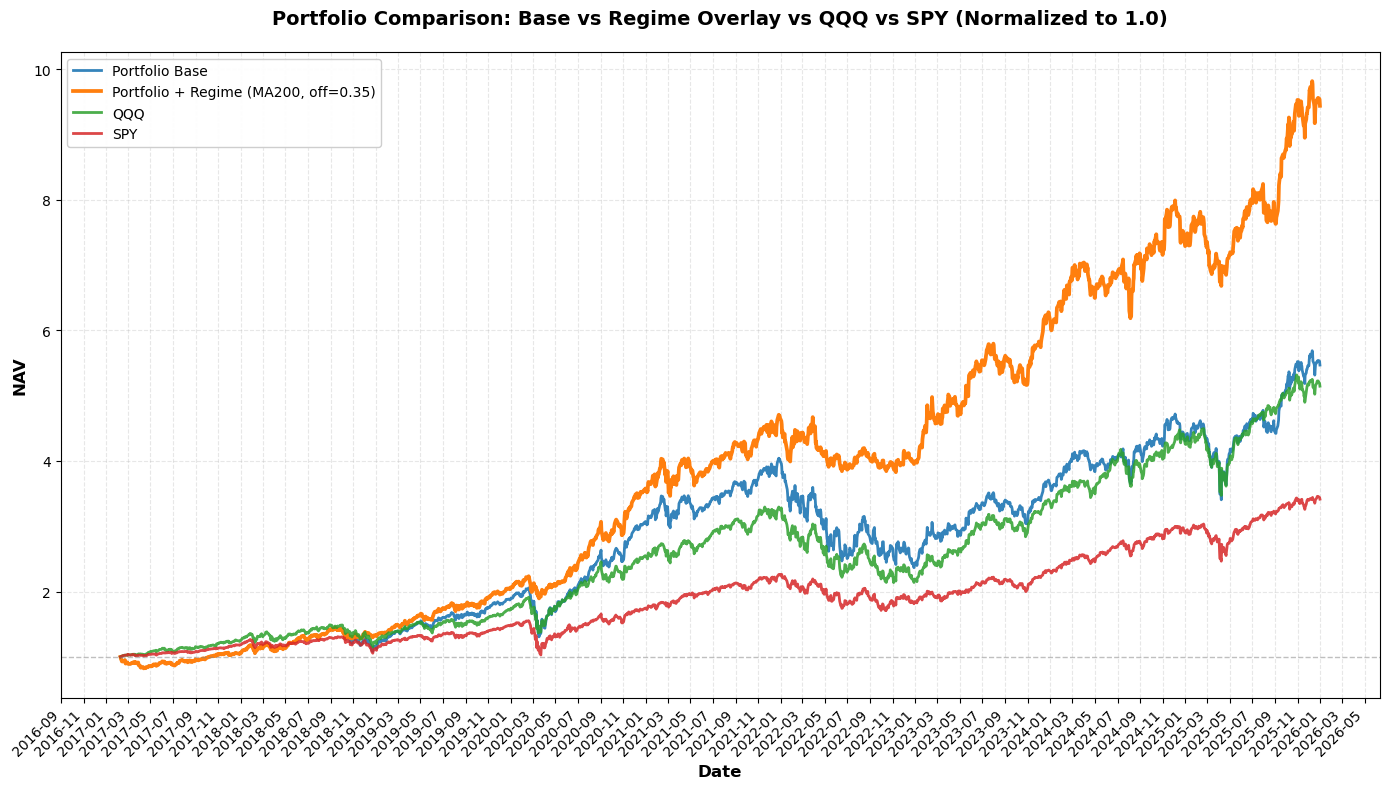

In [ ]:
# ============================================================
# Regime Overlay (SPY MA200) 
# - Ensures SPY close is a 1D Series
# - risk_off is 1D boolean Series aligned to trade_index
# - exposure is 1D Series
# - produces: Portfolio_Base, Portfolio_Regime, QQQ, SPY
# - saves: custom_strategy_metrics_regime.csv + portfolio_comparison_chart_regime.png
# ============================================================



trade_index = result_best.index[1:]  

# ---------- 1) Download SPY and force 1D close series ----------
spy_px = yf.download(
    "SPY",
    start=trade_index.min(),
    end=trade_index.max() + pd.Timedelta(days=1),
    progress=False,
    auto_adjust=True,
    group_by="column"
)

if spy_px is None or spy_px.empty:
    raise ValueError("SPY download is empty. Check internet / yfinance.")

# Force close to be a 1D Series
if isinstance(spy_px.columns, pd.MultiIndex):
    # try to grab Close level safely
    if "Close" in spy_px.columns.get_level_values(0):
        spy_close = spy_px["Close"]
        if isinstance(spy_close, pd.DataFrame):
            spy_close = spy_close.iloc[:, 0]
    elif "Close" in spy_px.columns.get_level_values(1):
        spy_close = spy_px.xs("Close", axis=1, level=1).iloc[:, 0]
    else:
        spy_close = spy_px.iloc[:, 0]
else:
    spy_close = spy_px["Close"] if "Close" in spy_px.columns else spy_px.iloc[:, 0]

spy_close = spy_close.dropna()
spy_close = spy_close.reindex(trade_index).ffill()  
spy_close = spy_close.astype(float)                

# ---------- 2) Compute MA200 + risk_off boolean (1D Series) ----------
spy_ma200 = spy_close.rolling(200, min_periods=200).mean()
risk_off = (spy_close < spy_ma200).fillna(False)    

# ---------- 3) Build exposure series (1D) ----------
exposure_on = 1.0
exposure_off = 0.35   

# IMPORTANT: use pandas where to keep 1D and preserve index
exposure = pd.Series(exposure_on, index=trade_index, dtype=float)
exposure.loc[risk_off] = exposure_off

# ---------- 4) Apply exposure to your portfolio daily returns ----------
net_ret_base = result_best.loc[trade_index, "net_ret"].astype(float)
net_ret_regime = net_ret_base * exposure

nav_base = (1.0 + net_ret_base).cumprod()
nav_regime = (1.0 + net_ret_regime).cumprod()

# normalize both to start at 1.0
nav_base = nav_base / nav_base.iloc[0]
nav_regime = nav_regime / nav_regime.iloc[0]

# ---------- 5) Benchmarks (QQQ/SPY) aligned ----------
bench = get_benchmark_nav(("QQQ", "SPY"), align_index=trade_index)

# ---------- 6) Build comparison_df (same style as your previous code) ----------
comparison_df = pd.DataFrame({
    "Portfolio_Base": nav_base,
    "Portfolio_Regime": nav_regime,
    "QQQ": bench["QQQ"],
    "SPY": bench["SPY"]
})

comparison_df = comparison_df.ffill().dropna()
comparison_df = comparison_df / comparison_df.iloc[0] 

print("Aligned data shape:", comparison_df.shape)
print("Date range:", comparison_df.index.min(), "to", comparison_df.index.max())

# ---------- 7) Metrics + save CSV ----------
metrics_df = pd.DataFrame({
    "Portfolio_Base": performance_metrics(comparison_df["Portfolio_Base"], freq=252, rf_annual=0.0),
    "Portfolio_Regime": performance_metrics(comparison_df["Portfolio_Regime"], freq=252, rf_annual=0.0),
    "QQQ": performance_metrics(comparison_df["QQQ"], freq=252, rf_annual=0.0),
    "SPY": performance_metrics(comparison_df["SPY"], freq=252, rf_annual=0.0),
}).T

metrics_out = os.path.join(output_path_step2, "custom_strategy_metrics_regime.csv")
metrics_df.to_csv(metrics_out)
print(f"✓ Metrics saved to: {metrics_out}")
print(metrics_df)

# ---------- 8) Plot + save PNG (same formatting style) ----------
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(comparison_df.index, comparison_df["Portfolio_Base"], label="Portfolio Base", linewidth=2.0, alpha=0.9)
ax.plot(comparison_df.index, comparison_df["Portfolio_Regime"],
        label=f"Portfolio + Regime (MA200, off={exposure_off})",
        linewidth=2.7)
ax.plot(comparison_df.index, comparison_df["QQQ"], label="QQQ", linewidth=2, alpha=0.85)
ax.plot(comparison_df.index, comparison_df["SPY"], label="SPY", linewidth=2, alpha=0.85)

ax.axhline(1.0, color="gray", linestyle="--", linewidth=1, alpha=0.5)

ax.set_xlabel("Date", fontsize=12, fontweight="bold")
ax.set_ylabel("NAV", fontsize=12, fontweight="bold")
ax.set_title("Portfolio Comparison: Base vs Regime Overlay vs QQQ vs SPY (Normalized to 1.0)",
             fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="best", framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle="--")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()

plot_out = os.path.join(output_path_step2, "portfolio_comparison_chart_regime.png")
plt.savefig(plot_out, dpi=300, bbox_inches="tight")
print(f"✓ Chart saved to: {plot_out}")

plt.show()

✓ Saved exposure grid: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/submissions/assigment1_HanGao_hg2783/output/step2/regime_exposure_grid.csv
   exposure_off  Portfolio_CumRet  Portfolio_AnnualReturn  \
0          0.20          9.503406                0.303637   
1          0.35          8.438454                0.288017   
2          0.50          7.421400                0.271565   

   Portfolio_AnnualVol  Portfolio_Sharpe  Portfolio_MaxDD  \
0             0.187899          1.505928        -0.175610   
1             0.195604          1.392482        -0.186708   
2             0.206915          1.265192        -0.239033   

   Excess_AnnualReturn_vs_QQQ  Excess_Sharpe_vs_QQQ  
0                    0.100792              0.589341  
1                    0.085173              0.475894  
2                    0.068721              0.348605  

✅ Best exposure_off by Sharpe: 0.2

✓ Saved metrics: /Users/gaohan/STAT-GR5398-Spring-2026/FinRL-Trading-Group/Assignment1/su

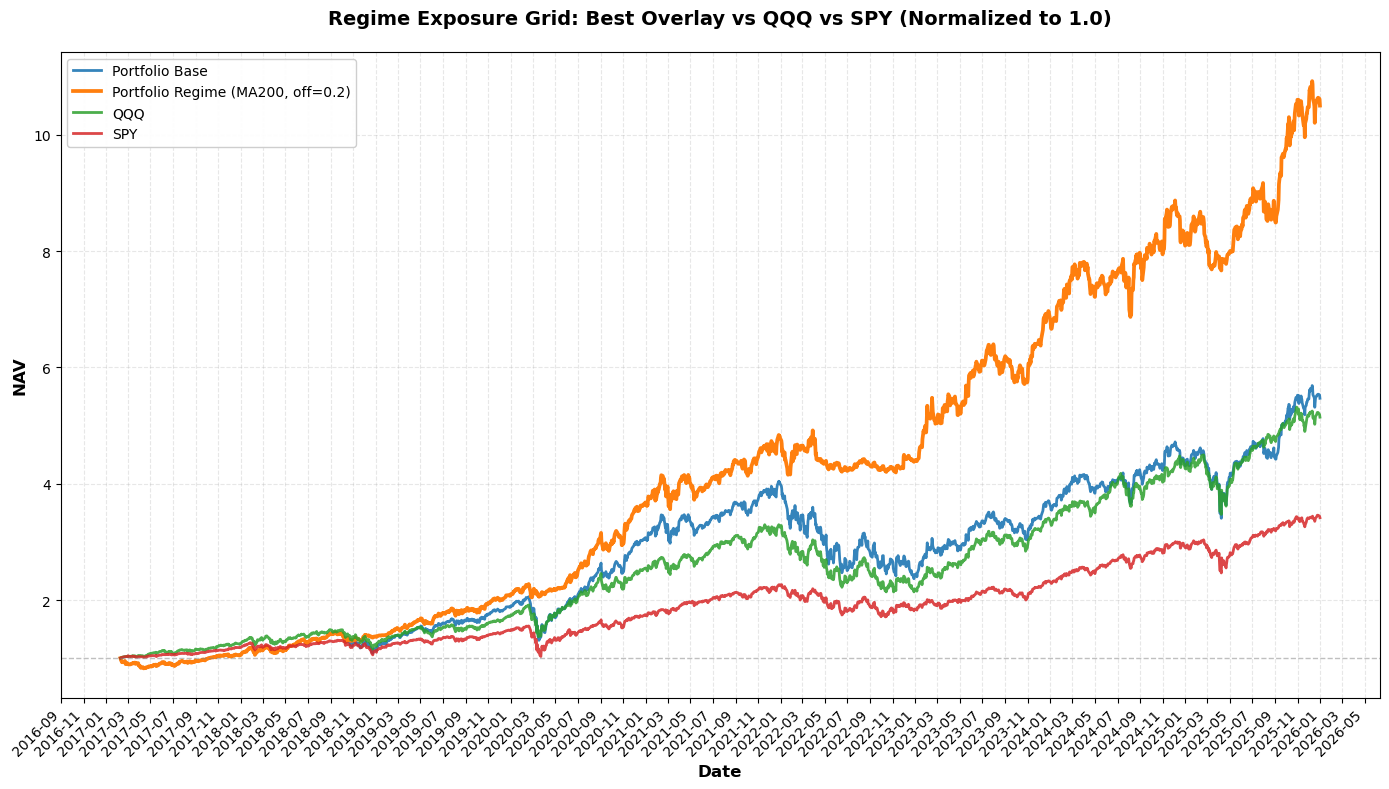

In [138]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------
# 0) Setup
# -------------------------
trade_index = result_best.index[1:]  # skip artificial row

# download SPY close (1D Series) and align
spy_px = yf.download(
    "SPY",
    start=trade_index.min(),
    end=trade_index.max() + pd.Timedelta(days=1),
    progress=False,
    auto_adjust=True,
    group_by="column"
)

if spy_px is None or spy_px.empty:
    raise ValueError("SPY download is empty. Check internet / yfinance.")

# force 1D close series
if isinstance(spy_px.columns, pd.MultiIndex):
    if "Close" in spy_px.columns.get_level_values(0):
        spy_close = spy_px["Close"]
        if isinstance(spy_close, pd.DataFrame):
            spy_close = spy_close.iloc[:, 0]
    elif "Close" in spy_px.columns.get_level_values(1):
        spy_close = spy_px.xs("Close", axis=1, level=1).iloc[:, 0]
    else:
        spy_close = spy_px.iloc[:, 0]
else:
    spy_close = spy_px["Close"] if "Close" in spy_px.columns else spy_px.iloc[:, 0]

spy_close = spy_close.dropna().reindex(trade_index).ffill().astype(float)

# regime rule: SPY < MA200 => risk_off
spy_ma200 = spy_close.rolling(200, min_periods=200).mean()
risk_off = (spy_close < spy_ma200).fillna(False)

# portfolio daily return (already cost-adjusted)
net_ret_base = result_best.loc[trade_index, "net_ret"].astype(float)

# benchmarks aligned
bench = get_benchmark_nav(("QQQ", "SPY"), align_index=trade_index)

# -------------------------
# 1) Grid over exposure_off
# -------------------------
exposure_on = 1.0
exposure_off_grid = [0.2, 0.35, 0.5]

rows = []
nav_dict = {}

for exposure_off in exposure_off_grid:
    exposure = pd.Series(exposure_on, index=trade_index, dtype=float)
    exposure.loc[risk_off] = exposure_off

    net_ret_regime = net_ret_base * exposure
    nav_regime = (1.0 + net_ret_regime).cumprod()
    nav_regime = nav_regime / nav_regime.iloc[0]

    # align/normalize for metrics (match your standard)
    tmp = pd.DataFrame({
        "Portfolio_Regime": nav_regime,
        "QQQ": bench["QQQ"],
        "SPY": bench["SPY"]
    }).ffill().dropna()
    tmp = tmp / tmp.iloc[0]

    m_port = performance_metrics(tmp["Portfolio_Regime"], freq=252, rf_annual=0.0)
    m_qqq = performance_metrics(tmp["QQQ"], freq=252, rf_annual=0.0)

    rows.append({
        "exposure_off": exposure_off,
        "Portfolio_CumRet": m_port["Cumulative Return"],
        "Portfolio_AnnualReturn": m_port["Annual Return"],
        "Portfolio_AnnualVol": m_port["Annual Volatility"],
        "Portfolio_Sharpe": m_port["Sharpe Ratio"],
        "Portfolio_MaxDD": m_port["Max Drawdown"],
        "Excess_AnnualReturn_vs_QQQ": m_port["Annual Return"] - m_qqq["Annual Return"],
        "Excess_Sharpe_vs_QQQ": m_port["Sharpe Ratio"] - m_qqq["Sharpe Ratio"],
    })

    nav_dict[exposure_off] = tmp["Portfolio_Regime"]

grid_df = pd.DataFrame(rows).sort_values("Portfolio_Sharpe", ascending=False)

# save grid results
grid_out = os.path.join(output_path_step2, "regime_exposure_grid.csv")
grid_df.to_csv(grid_out, index=False)
print(f"✓ Saved exposure grid: {grid_out}")
print(grid_df)

# choose best by Sharpe (you can change objective if you want)
best_row = grid_df.iloc[0]
best_exposure_off = float(best_row["exposure_off"])
print("\n✅ Best exposure_off by Sharpe:", best_exposure_off)

# -------------------------
# 2) Build final comparison_df with best exposure
# -------------------------
nav_base = (1.0 + net_ret_base).cumprod()
nav_base = nav_base / nav_base.iloc[0]

comparison_df = pd.DataFrame({
    "Portfolio_Base": nav_base,
    f"Portfolio_Regime_off_{best_exposure_off}": nav_dict[best_exposure_off],
    "QQQ": bench["QQQ"],
    "SPY": bench["SPY"]
}).ffill().dropna()

comparison_df = comparison_df / comparison_df.iloc[0]

# metrics table
metrics_df = pd.DataFrame({
    "Portfolio_Base": performance_metrics(comparison_df["Portfolio_Base"], freq=252, rf_annual=0.0),
    f"Portfolio_Regime_off_{best_exposure_off}": performance_metrics(comparison_df[f"Portfolio_Regime_off_{best_exposure_off}"], freq=252, rf_annual=0.0),
    "QQQ": performance_metrics(comparison_df["QQQ"], freq=252, rf_annual=0.0),
    "SPY": performance_metrics(comparison_df["SPY"], freq=252, rf_annual=0.0),
}).T

metrics_out = os.path.join(output_path_step2, "custom_strategy_metrics_regime_best_exposure.csv")
metrics_df.to_csv(metrics_out)
print(f"\n✓ Saved metrics: {metrics_out}")
print(metrics_df)

# -------------------------
# 3) Plot
# -------------------------
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(comparison_df.index, comparison_df["Portfolio_Base"], label="Portfolio Base", linewidth=2.0, alpha=0.9)
ax.plot(comparison_df.index, comparison_df[f"Portfolio_Regime_off_{best_exposure_off}"],
        label=f"Portfolio Regime (MA200, off={best_exposure_off})", linewidth=2.7)
ax.plot(comparison_df.index, comparison_df["QQQ"], label="QQQ", linewidth=2, alpha=0.85)
ax.plot(comparison_df.index, comparison_df["SPY"], label="SPY", linewidth=2, alpha=0.85)

ax.axhline(1.0, color="gray", linestyle="--", linewidth=1, alpha=0.5)
ax.set_xlabel("Date", fontsize=12, fontweight="bold")
ax.set_ylabel("NAV", fontsize=12, fontweight="bold")
ax.set_title("Regime Exposure Grid: Best Overlay vs QQQ vs SPY (Normalized to 1.0)",
             fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="best", framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle="--")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()

plot_out = os.path.join(output_path_step2, "portfolio_comparison_chart_regime_best_exposure.png")
plt.savefig(plot_out, dpi=300, bbox_inches="tight")
print(f"✓ Saved plot: {plot_out}")
plt.show()